# Run 68 Capture Estimate

It seems as if K100 Run 68 at UMN has a significantly [higher threshold][R68_thresh] than Run 62 for the silicon HV detector.  This means that the accessible part of the spectrum from a neutron capture measurement will be less. Here I estimate that scenario.  

[R68_thresh]: https://zzz.physics.umn.edu/cdms/doku.php?id=cdms:k100:run_summary:run_68#noise_width_threshold_versus_bias "R68 Threshold"

In [1]:
import pickle as pkl
lifetimes='fast'

#load up some cascade simulated data; 20k cascade events
with open('/data/chocula/villaa/cascadeSimData/normsi_Quant_{0}.pkl'.format(lifetimes),'rb') as readFile:
      cdata=pkl.load(readFile,encoding='latin1')

#print(cdata.keys())

In [2]:
import numpy as np

#get the true reate
ddet = 10 #10 cm detector diameter
tdet = 3.33 #33 cm thickness
Vol = np.pi*(ddet/2.0)**2*tdet #close to what the volume of detector is
Sig_cap = 0.008572
f = 0.1 #assume approximate desired flux
rho_si = 2.329 #g/cm^3 approximate r.t. density (what is the change at 50mK?)
Mass=Vol*rho_si
print('detector is {0:1.2f} cm^3'.format(Vol))
print('detector is {0:1.2f} kg'.format(Mass/1000))

#get counts per gram day
cpgd = ((f*Sig_cap*Vol)/(Vol*rho_si))*(24*60*60)
cpkgd = cpgd * 1000

detector is 261.54 cm^3
detector is 0.61 kg


In [3]:
import damic_y as dy 

#a spline extrapolation to DAMIC data
damic_y = dy.getDAMICy()

#get the summed deposited energy object
Edep = np.sum(cdata['delE'],1)

#Prepare for the computation mentioned above
E = cdata['E']
dE = cdata['delE']
damic_yv = np.vectorize(damic_y) #vectorize it
Eee = E*damic_yv(E) - (E-dE)*damic_yv(E-dE)

dict_keys(['xx', 'yy', 'ex', 'ey'])


In [4]:
eps = 3.8 #eV for silicon
F = 0.1161 #silicon value taken from https://www.sciencedirect.com/science/article/pii/S0168900297009650
F = 1 # Fano for NRs is probably unity
#F = 2 # Fano is a lil larger
#F = 5 # Fano for NRs might be medium
#F = 10 # Fano for NRs might be huge

#simplistic gaussian model for charge to get width and mean correct
N = np.round(np.random.normal((Eee/eps),np.sqrt(F*(Eee/eps)),np.shape(Eee))) #discretize a normal distribution


#set detector/run parameters
V=50. #Voltage of expected device spectrum
#res=np.sqrt(250**2 + 250**2)
res = 250
thresh = 50 #eVee
max_thresh = 175
sigthr = 0.2*thresh #20% ? 
max_sigthr = 0.2*max_thresh #20% ? 
tagg_eff = 1e-2 #tagging efficiency, 1% guess
tagg_eff = 1
gesc_eff = 0.9 #for Silicon have about a 10% chance of gammas interacting on the way out

#get the total phonon energy
Et_step = N*V + dE
Et = np.sum(Et_step,1)
Et = Et + np.random.normal(0,res,np.shape(Et)) #add resolution

#convert to eVee scale by making the gamma assumption
evee_scale = (1+(V/eps))
Eee_g = Et/evee_scale

In [5]:
#get histogram
emax = 500 #emax in eV

n,nx = np.histogram(Eee_g,1000,range=(0,emax))

xc = (nx[:-1] + nx[1:]) / 2

#get the event-number and energy normalization
norm = 1/(np.double(cdata['totalevents'])) #normalize per capture
n = np.double(n)/np.diff(nx); #divide by bin width

#normalize
norm*=cpkgd
norm*=tagg_eff
norm*=gesc_eff
n = np.double(n)*norm

In [6]:
#set up a plot 
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerLine2D
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

==========Low Threshold=============
Total event rate: 2.71E+04 events/kg-day
Total event rate: 1.65E+04 events/det-day
Total events (1 detector, 10 days): 1.65E+05 events

==========Max Useable Threshold=============
Total event rate: 1.34E+03 events/kg-day
Total event rate: 8.18E+02 events/det-day
Total events (1 detector, 10 days): 8.18E+03 events


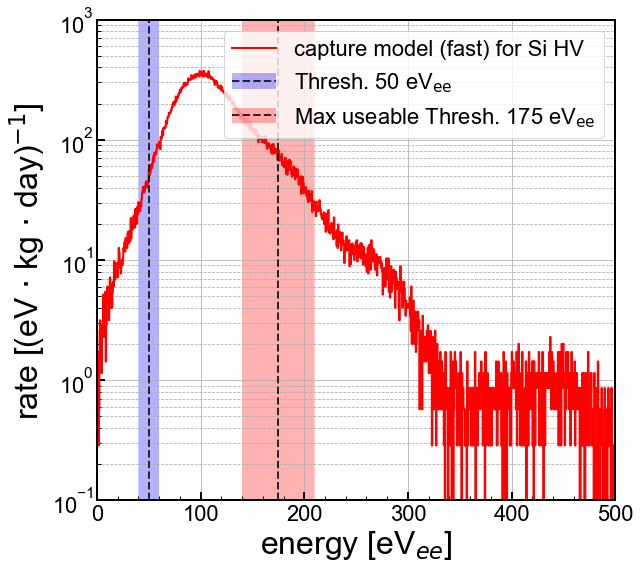

In [7]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

hlabel='capture model ({}) for Si HV'.format(lifetimes)
step, = ax1.step(xc,n, where='mid',color='r', linestyle='-', label=hlabel, linewidth=2)


print('==========Low Threshold=============')
print('Total event rate: {0:1.2E} events/kg-day'.format(np.sum(n[xc>thresh+sigthr]*np.diff(nx)[xc>thresh+sigthr])))
print('Total event rate: {0:1.2E} events/det-day'.format((Mass/1000)*np.sum(n[xc>thresh+sigthr]* \
                                                                            np.diff(nx)[xc>thresh+sigthr])))
print('Total events (1 detector, 10 days): {0:1.2E} events'.format(10*(Mass/1000)*np.sum(n[xc>thresh+sigthr]* \
                                                                            np.diff(nx)[xc>thresh+sigthr])))

print('')

print('==========Max Useable Threshold=============')
print('Total event rate: {0:1.2E} events/kg-day'.format(np.sum(n[xc>max_thresh+max_sigthr]* \
                                                               np.diff(nx)[xc>max_thresh+max_sigthr])))
print('Total event rate: {0:1.2E} events/det-day'.format((Mass/1000)*np.sum(n[xc>max_thresh+max_sigthr]* \
                                                                            np.diff(nx)[xc>max_thresh+max_sigthr])))
print('Total events (1 detector, 10 days): {0:1.2E} events'.format(10*(Mass/1000)*np.sum(n[xc>max_thresh+max_sigthr]* \
                                                                            np.diff(nx)[xc>max_thresh+max_sigthr])))
ymin = 1e-1
ymax = 1e3


tlabel = 'Thresh. {0} eV$_{{\mathrm{{ee}}}}$'.format(thresh)
max_tlabel = 'Max useable Thresh. {0} eV$_{{\mathrm{{ee}}}}$'.format(max_thresh)
tline = ax1.axvline(thresh, color='k', linestyle='--', lw=2, alpha=0.8,label=tlabel)
mtline = ax1.axvline(max_thresh, color='k', linestyle='--', lw=2, alpha=0.8,label=max_tlabel)
erange_x = np.arange(thresh-sigthr, thresh+sigthr, 0.01)
tshade = ax1.fill_between(erange_x, ymin, ymax, facecolor='b', alpha=0.3)
erange_x = np.arange(max_thresh-max_sigthr, max_thresh+max_sigthr, 0.01)
mtshade = ax1.fill_between(erange_x, ymin, ymax, facecolor='r', alpha=0.3)


ax1.set_yscale('log')
ax1.set_xlim(0, emax) #in pairs
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('energy [eV$_{ee}$]',**axis_font)
ax1.set_ylabel('rate [(eV $\cdot$ kg $\cdot$ day)$^{-1}$]',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend(loc=1,prop={'size':22})
ax1.legend([step,(tshade, tline),(mtshade,mtline)], [hlabel,tlabel,max_tlabel], handler_map = {tline : HandlerLine2D(marker_pad = 0)} ,loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/R68_SiHV_threshold_estimate_F{0:02d}.png'.format(F))
plt.show()

In [8]:
#get the total number of events expected over exposure of single detector
EvPerDay = (Mass/1000)*np.sum(n[xc>thresh+sigthr]*np.diff(nx)[xc>thresh+sigthr])
Days=10 #expected exposure length
Ev = EvPerDay*Days

print(np.int(np.round(Ev)))

165188


In [9]:
#restrict spectrum to that number of events
idx = np.arange(np.shape(Eee_g)[0])
idx_rand = np.random.choice(idx,np.int(np.round(Ev)),replace=False)

Eee_g_reduced = Eee_g[idx_rand]
print(np.shape(Eee_g))
print(np.shape(Eee_g_reduced))

(200000,)
(165188,)


In [10]:
#get new histogram
n_red,nx_red = np.histogram(Eee_g_reduced,1000,range=(0,emax))

xc_red = (nx_red[:-1] + nx_red[1:]) / 2

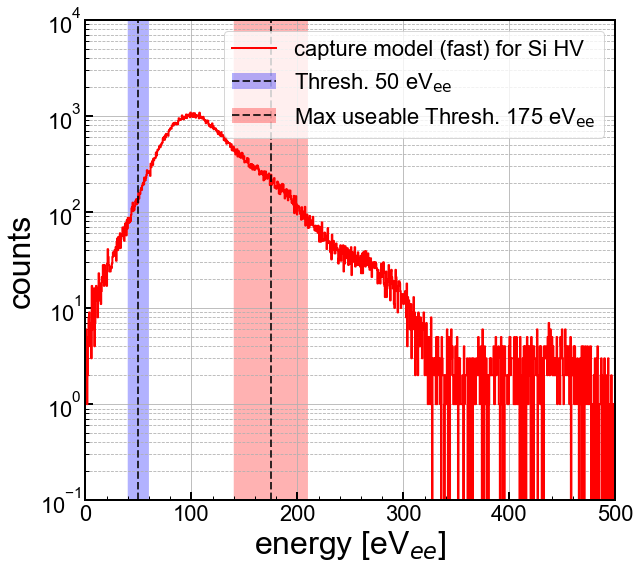

In [11]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

hlabel='capture model ({}) for Si HV'.format(lifetimes)
step, = ax1.step(xc_red,n_red, where='mid',color='r', linestyle='-', label=hlabel, linewidth=2)


ymin = 1e-1
ymax = 1e4


tlabel = 'Thresh. {0} eV$_{{\mathrm{{ee}}}}$'.format(thresh)
max_tlabel = 'Max useable Thresh. {0} eV$_{{\mathrm{{ee}}}}$'.format(max_thresh)
tline = ax1.axvline(thresh, color='k', linestyle='--', lw=2, alpha=0.8,label=tlabel)
mtline = ax1.axvline(max_thresh, color='k', linestyle='--', lw=2, alpha=0.8,label=max_tlabel)
erange_x = np.arange(thresh-sigthr, thresh+sigthr, 0.01)
tshade = ax1.fill_between(erange_x, ymin, ymax, facecolor='b', alpha=0.3)
erange_x = np.arange(max_thresh-max_sigthr, max_thresh+max_sigthr, 0.01)
mtshade = ax1.fill_between(erange_x, ymin, ymax, facecolor='r', alpha=0.3)


ax1.set_yscale('log')
ax1.set_xlim(0, emax) #in pairs
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('energy [eV$_{ee}$]',**axis_font)
ax1.set_ylabel('counts',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend(loc=1,prop={'size':22})
ax1.legend([step,(tshade, tline),(mtshade,mtline)], [hlabel,tlabel,max_tlabel], handler_map = {tline : HandlerLine2D(marker_pad = 0)} ,loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/R68_SiHV_threshold_counts_F{0:02d}.png'.format(F))
plt.show()